# Estimating alcohol content in red wines

* Author: Martin Rožnovják
* Last edited: 2019-02-25
* Organization: Metropolia University of Applied Sciences

## What is this?

This notebook is a school assignment for a course called *Cognitive Systems - Mathematics and Methods*.


The task is to make a diagnostic tool (based on logistic regression and not for real medical use) that asks a medical expert six numerical quantities obtained by radiographic measurements of a patient:
1. pelvic incidence
2. pelvic tilt
3. lumbar lordosis angle
4. sacral slope
5. pelvic radius
6. grade of spondylolisthesis

We will be using the following UCI dataset http://archive.ics.uci.edu/ml/datasets/Vertebral+Column.

## Let's begin
### All the necessary imports

In [1]:
import sklearn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

Setting options, in particular those for plotting, often interferes with Jupyter's own initializations on import. Therefore, I just do it in the next cell.

In [2]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

### Fetching the dataset

In [3]:
spines_df = pd.read_table(
    'ignored/column_3C.dat',
    sep=' ',
    names=[
        'pelvic_incidence',
        'pelvic_tilt',
        'lumbar_lordosis_angle',
        'sacral_slope',
        'pelvic_radius',
        'degree_spondylolisthesis',
        'diagnosis'
    ]
)

# a peek whether it went alright
spines_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,diagnosis
0,63.030,22.550,39.610,40.480,98.670,-0.250,DH
1,39.060,10.060,25.020,29.000,114.410,4.560,DH
2,68.830,22.220,50.090,46.610,105.990,-3.530,DH
3,69.300,24.650,44.310,44.640,101.870,11.210,DH
4,49.710,9.650,28.320,40.060,108.170,7.920,DH


### Basic stats and info

In [4]:
print('Summary:')
spines_df.info();

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
diagnosis                   310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.0+ KB


In [5]:
print('Basic descriptive statistics:')
spines_df.describe()

Basic descriptive statistics:


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000,310.000,310.000,310.000,310.000,310.000
mean,60.496,17.543,51.931,42.954,117.921,26.297
std,17.236,10.008,18.554,13.423,13.318,37.559
min,26.150,-6.550,14.000,13.370,70.080,-11.060
25%,46.432,10.668,37.000,33.348,110.710,1.600
50%,58.690,16.360,49.565,42.405,118.265,11.765
75%,72.880,22.120,63.000,52.692,125.468,41.285
max,129.830,49.430,125.740,121.430,163.070,418.540


The max value for degree spondylolisthesis looks like an error since it's about 10 times the 75% quantile.

Parallel coordinates plot:


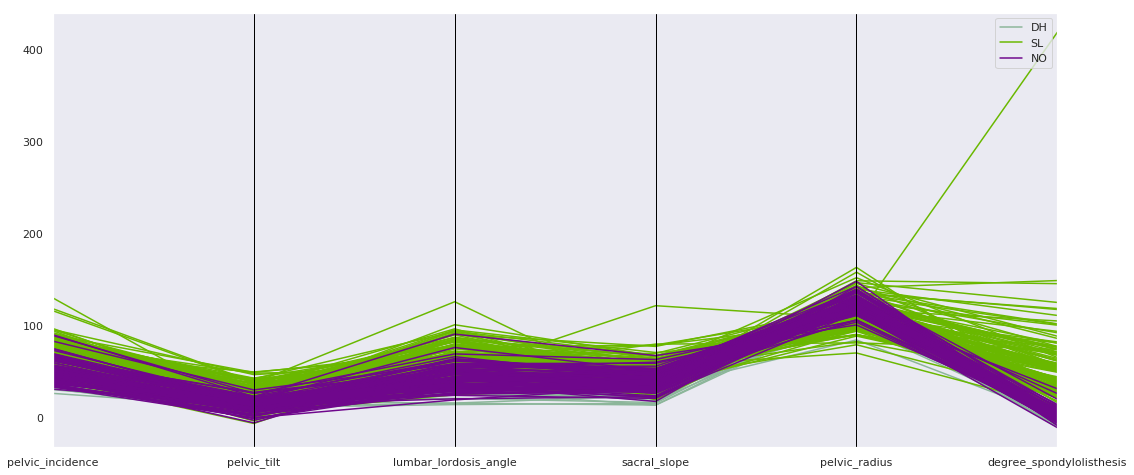

In [6]:
print('Parallel coordinates plot:')
pd.plotting.parallel_coordinates(spines_df, 'diagnosis');

Let's find and remove it, others are relatively okay...

In [7]:
spines_df.drop(
    index=spines_df['degree_spondylolisthesis'].idxmax(),
    inplace=True
)
spines_df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,309.000,309.000,309.000,309.000,309.000,309.000
mean,60.272,17.572,51.942,42.700,117.954,25.027
std,16.804,10.011,18.583,12.677,13.326,30.234
min,26.150,-6.550,14.000,13.370,70.080,-11.060
25%,46.430,10.690,37.000,33.340,110.710,1.590
50%,58.600,16.420,49.780,42.370,118.340,11.460
75%,72.640,22.180,63.000,52.550,125.480,40.880
max,118.140,49.430,125.740,79.700,163.070,148.750


Another (rescaled) look at parallel coordinates plot:


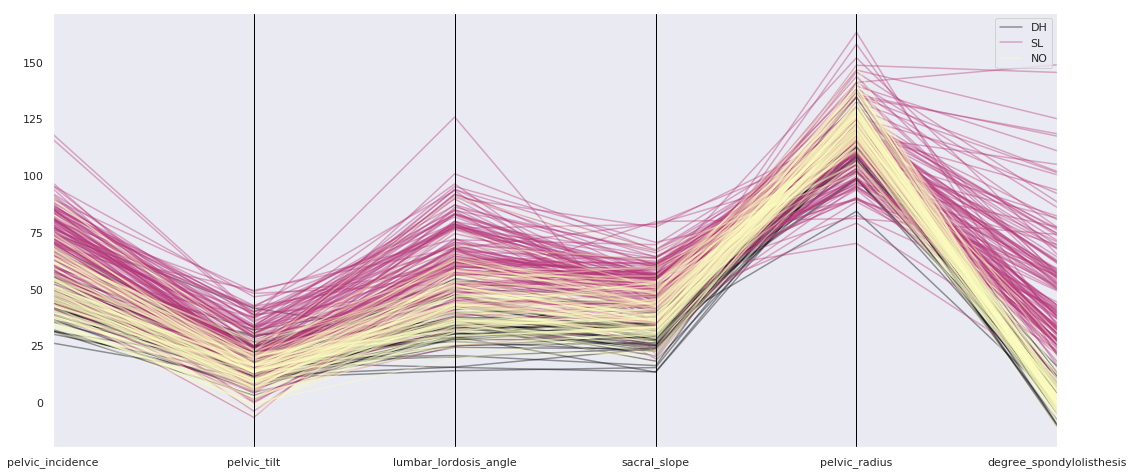

In [8]:
print('Another (rescaled) look at parallel coordinates plot:')
pd.plotting.parallel_coordinates(spines_df, 'diagnosis', alpha=0.4, colormap='magma');

Boxes, whiskars, (kitties?):


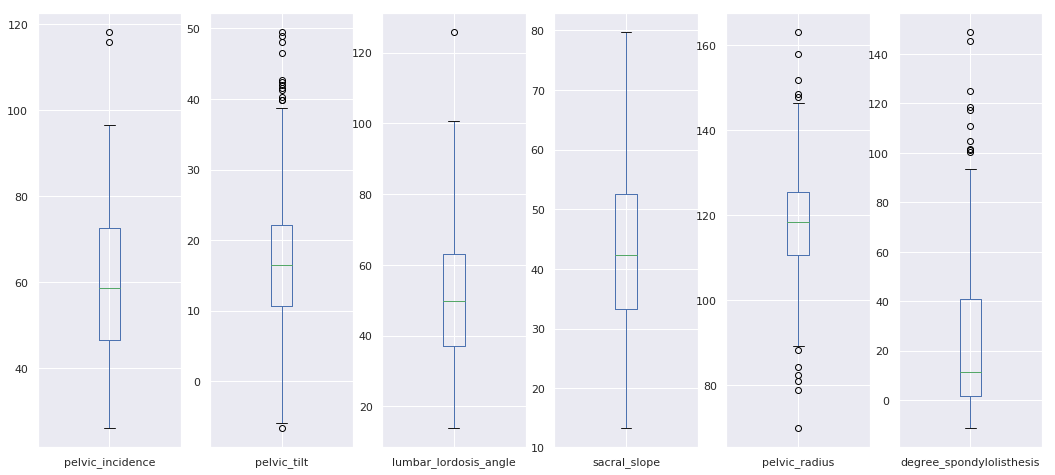

In [9]:
print('Boxes, whiskars, (kitties?):')
spines_df.plot.box(subplots=True);

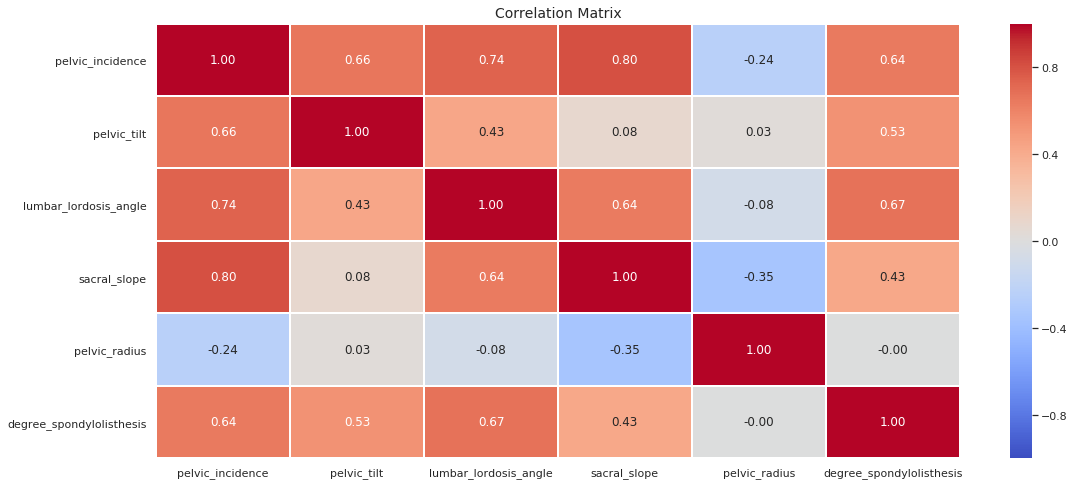

In [10]:
ax = sns.heatmap(
    spines_df.corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    fmt='0.2f',
    linewidths=1,
)
ax.set_title('Correlation Matrix');

There are quite worrisome correlations, some tweaking might be necessary... or it will be possible to get rid of some columns without sacrificing much accuracy.

### Regression

I am quite curious about both, regressing into all three classes
and also about binary regression - whetere the condition is normal or abnormal.
So I will create a new column for the binary regression.

In [11]:
# the normal or not classification
spines_df['normal'] = (spines_df.diagnosis == 'NO')

In [12]:
# shuffle a bit...
spines_df = spines_df.sample(frac=1).reset_index(drop=True)

In [13]:
# I found out that Newton-CG found better fits,
# so did One-versus-rest method in comparison
# to multinomial logistic regression.
# So this will be enough for the examples.
reg = LogisticRegression(
    solver='newton-cg',
    multi_class='ovr',
)

In [14]:
print('Ternary classification, all columns:')
columns = [
    'pelvic_incidence',
    'pelvic_tilt',
    'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'degree_spondylolisthesis',
]

X = spines_df[columns]
y = spines_df.diagnosis

scores = sklearn.model_selection.cross_validate(
    reg, X, y, cv=10,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=True,
)

pd.DataFrame(scores).describe()

Ternary classification, all columns:


,fit_time,score_time,test_accuracy,train_accuracy,test_f1_macro,train_f1_macro,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.070,0.003,0.861,0.871,0.820,0.830,0.834,0.836,0.817,0.826
std,0.019,0.000,0.059,0.006,0.079,0.010,0.085,0.009,0.079,0.010
min,0.061,0.003,0.774,0.863,0.677,0.817,0.679,0.825,0.678,0.812
25%,0.062,0.003,0.839,0.867,0.801,0.822,0.806,0.830,0.800,0.818
50%,0.064,0.003,0.871,0.871,0.829,0.829,0.837,0.835,0.817,0.826
75%,0.065,0.003,0.893,0.876,0.858,0.838,0.889,0.840,0.856,0.835
max,0.122,0.004,0.968,0.881,0.957,0.845,0.952,0.854,0.967,0.841


In [15]:
print('Ternary classification, pelvic incidence dropped:')
columns = [
#     'pelvic_incidence',
    'pelvic_tilt',
    'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'degree_spondylolisthesis',
]

X = spines_df[columns]
y = spines_df.diagnosis

scores = sklearn.model_selection.cross_validate(
    reg, X, y, cv=10,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False,
)

pd.DataFrame(scores).describe()

Ternary classification, pelvic incidence dropped:


,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
count,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.060,0.003,0.861,0.820,0.834,0.817
std,0.005,0.000,0.059,0.079,0.085,0.079
min,0.053,0.003,0.774,0.677,0.679,0.678
25%,0.056,0.003,0.839,0.801,0.806,0.800
50%,0.059,0.003,0.871,0.829,0.837,0.817
75%,0.063,0.003,0.893,0.858,0.889,0.856
max,0.068,0.003,0.968,0.957,0.952,0.967


In [16]:
print('Binary classification, all columns:')
columns = [
    'pelvic_incidence',
    'pelvic_tilt',
    'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'degree_spondylolisthesis',
]

X = spines_df[columns]
y = spines_df.normal

scores = sklearn.model_selection.cross_validate(
    reg, X, y, cv=10,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=True,
)

pd.DataFrame(scores).describe()

Binary classification, all columns:


,fit_time,score_time,test_accuracy,train_accuracy,test_f1_macro,train_f1_macro,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.022,0.003,0.855,0.858,0.836,0.838,0.837,0.837,0.838,0.840
std,0.003,0.000,0.061,0.006,0.067,0.006,0.072,0.007,0.061,0.006
min,0.017,0.003,0.774,0.849,0.748,0.827,0.743,0.827,0.755,0.827
25%,0.021,0.003,0.815,0.853,0.786,0.833,0.787,0.830,0.786,0.837
50%,0.022,0.003,0.855,0.860,0.836,0.840,0.837,0.838,0.840,0.840
75%,0.023,0.003,0.893,0.860,0.876,0.841,0.876,0.840,0.869,0.844
max,0.026,0.003,0.968,0.867,0.962,0.848,0.977,0.849,0.950,0.847


In [17]:
print('Binary classification, pelvic incidence and tilt dropped:')
columns = [
#     'pelvic_incidence',
#     'pelvic_tilt',
    'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'degree_spondylolisthesis',
]

X = spines_df[columns]
y = spines_df.normal

scores = sklearn.model_selection.cross_validate(
    reg, X, y, cv=10,
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    return_train_score=False,
)

pd.DataFrame(scores).describe()

Binary classification, pelvic incidence and tilt dropped:


,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
count,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.016,0.003,0.842,0.821,0.820,0.825
std,0.003,0.000,0.070,0.080,0.081,0.079
min,0.013,0.003,0.742,0.705,0.705,0.705
25%,0.014,0.003,0.782,0.763,0.759,0.779
50%,0.016,0.003,0.839,0.820,0.814,0.829
75%,0.018,0.003,0.894,0.881,0.876,0.889
max,0.023,0.003,0.968,0.962,0.977,0.950


In [18]:
print('Ternary classification, all data, some columns\n')
columns = [
#     'pelvic_incidence',
#     'pelvic_tilt',
#     'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'degree_spondylolisthesis',
]

X = spines_df[columns]
y = spines_df.diagnosis

reg.fit(X,y)
y_pred = reg.predict(X)

print('Intercept:', reg.intercept_)
print(f'Coefficients:\n{reg.coef_}\n')

cm = sklearn.metrics.confusion_matrix(y, y_pred)
print(f'Confusion matrix:\n{cm}\n')

accuracy =  cm.trace()/cm.sum()
print(f'Accuracy: {accuracy:.3f}\n')

print(sklearn.metrics.classification_report(
    y, y_pred,
    target_names=('Disk Hernia', 'Normal', 'Spondylolisthesis')
))

Ternary classification, all data, some columns

Intercept: [20.292 -18.031 -6.102]
Coefficients:
[[-0.189 -0.119 -0.102]
 [0.117 0.121 -0.165]
 [0.089 -0.021 0.283]]

Confusion matrix:
[[ 40  18   2]
 [ 11  86   3]
 [  0   5 144]]

Accuracy: 0.874

                   precision    recall  f1-score   support

      Disk Hernia       0.78      0.67      0.72        60
           Normal       0.79      0.86      0.82       100
Spondylolisthesis       0.97      0.97      0.97       149

        micro avg       0.87      0.87      0.87       309
        macro avg       0.85      0.83      0.84       309
     weighted avg       0.87      0.87      0.87       309



## Conclusion

I was surprised by the following observations:
1. dropping column(s) could even improve the predictions
   (I expected equal or slightly worse performance, but then
   realized that this might be due to overfitting)
2. ternary classification seemed to perform better,
   that might be attributed to model ensembly
3. quite low overfitting

About the "diagnostic tool" I leave a hardwired formula inspired by the last cell, the reason is that it would be actually easy to do this calculation quickly by hand and it still is very accurate. It could be simplified even further in exchange for accuracy. I found this more interesting than doing only `reg.pred(...)` with input handling...

In [19]:
def diagnose(
    ss: 'sacral_slope',
    pr: 'pelvic_radius',
    ds: 'degree_spondylolisthesis',
    labels = ('DH', 'NO', 'SL') #('Disk Hernia', 'Normal', 'Spondylolisthesis')
):
    """
    A streamlined model for DH/SL diagnosis with more than 80% overall accuracy.
    This can be easily and quickly calculated by hand if needed.
    
    Note: very good in correctly diagnosing spondylolisthesis,
          however, recall of disk hermia is low (around 60%),
          and precision is low for normal condition (around 70%).
    """
    x = np.array([1.0, ss, pr, ds])
    pred = diagnose.MODEL @ x
    diag_index = np.argmax(pred)
    
    return labels[diag_index]
    
diagnose.MODEL =  np.array([
    [ 20.3, -0.19, -0.12, -0.10],
    [-18.0,  0.12,  0.12, -0.17],
    [ -6.1,  0.09, -0.02,  0.28],
])

In [20]:
print('Performance of streamlined diagnostic tool\n')
yy = [diagnose(*row) for row in X.values]
cm = sklearn.metrics.confusion_matrix(y, yy)
print(f'Confusion matrix:\n{cm}\n')

accuracy =  cm.trace()/cm.sum()
print(f'Accuracy: {accuracy:.3f}\n')

print(sklearn.metrics.classification_report(
    y, yy,
    target_names=('Disk Hernia', 'Normal', 'Spondylolisthesis')
))

Performance of streamlined diagnostic tool

Confusion matrix:
[[ 39  19   2]
 [ 11  86   3]
 [  0   5 144]]

Accuracy: 0.871

                   precision    recall  f1-score   support

      Disk Hernia       0.78      0.65      0.71        60
           Normal       0.78      0.86      0.82       100
Spondylolisthesis       0.97      0.97      0.97       149

        micro avg       0.87      0.87      0.87       309
        macro avg       0.84      0.83      0.83       309
     weighted avg       0.87      0.87      0.87       309



In [21]:
def dialogue():
    print("Please input patient's data")
    ss = float(input('Sacral slope: '))
    pr = float(input('Pelvic radius: '))
    ds = float(input('Grade of spondylolisthesis: '))
    
    condition = diagnose(
        ss, pr, ds,
        labels=('Disk Hernia', 'Normal', 'Spondylolisthesis')
    )
    
    print("Patient's likely condition:", condition)

In [22]:
dialogue()

Please input patient's data
Sacral slope: 40.5
Pelvic radius: 98.7
Grade of spondylolisthesis: -0.25
Patient's likely condition: Disk Hernia


Above is from the first entry (classified correctly):
63.03 22.55 39.61 **40.48 98.67 -0.25 DH**